# Week 2 Seminar

Top-pop recommender, metrics

In [1]:
import json
import random
import copy
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_json("/home/nikolay/Documents/made/semester2/recsys-made-2022/tmp/data.json", lines=True)
data["rnd"] = np.random.random(len(data))

data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2022-06-28 13:36:50.825,1984,1228,1.00,0.000581,6446.0,"{'AA': 'T1', 'RECOMMENDERS': 'T3'}",0.576015
1,next,2022-06-28 13:36:50.828,1984,6446,0.80,0.000322,7443.0,"{'AA': 'T1', 'RECOMMENDERS': 'T3'}",0.985098
2,next,2022-06-28 13:36:50.831,1984,7443,0.64,0.000452,36419.0,"{'AA': 'T1', 'RECOMMENDERS': 'T3'}",0.358342
3,next,2022-06-28 13:36:50.834,1984,36419,0.51,0.000328,35722.0,"{'AA': 'T1', 'RECOMMENDERS': 'T3'}",0.875841
4,next,2022-06-28 13:36:50.838,1984,35722,0.41,0.000427,20892.0,"{'AA': 'T1', 'RECOMMENDERS': 'T3'}",0.340605


## Compute track popularity

In [3]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,175,10.38
1,1115,9.77
2,246,9.39
3,1476,8.26
4,171,7.86


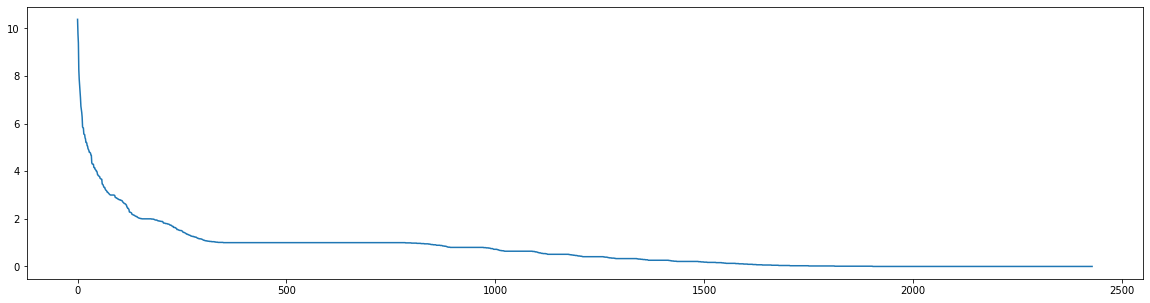

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

## Compute offline metrics

In [5]:
tracks = track_popularity["track"].tolist()
metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

In [6]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)


# TODO 1: Implement MRR here:
def mrr(recommendations, track):
    return 1.0 / (1.0 + recommendations.index(track)) if track in recommendations else 0.0

def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

### 1. Precision@k

In [7]:
p_10_udf = lambda track: precision_at(tracks[:10], track, 10)
sh_10_p_10_udf = lambda track: shuffled_precision_at(tracks[:10], track, 10)
sh_100_p_10_udf = lambda track: shuffled_precision_at(tracks[:100], track, 10)
sh_1000_p_10_udf = lambda track: shuffled_precision_at(tracks[:1000], track, 10)

In [8]:
metrics["p_10"] = metrics["track"].map(p_10_udf)
metrics["sh_10_p_10"] = metrics["track"].map(sh_10_p_10_udf)
metrics["sh_100_p_10"] = metrics["track"].map(sh_100_p_10_udf)
metrics["sh_1000_p_10"] = metrics["track"].map(sh_1000_p_10_udf)

In [9]:
metrics[["p_10", "sh_10_p_10", "sh_100_p_10", "sh_1000_p_10"]].describe()

,p_10,sh_10_p_10,sh_100_p_10,sh_1000_p_10
count,1343.000000,1343.000000,1343.000000,1343.000000
mean,0.003276,0.003276,0.002159,0.000298
std,0.017808,0.017808,0.014541,0.005451
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


### 2. MRR

In [10]:
# TODO 2: Apply MRR here:
mrr_10_udf = lambda track: mrr(tracks[:10], track)
sh_10_mrr_10_udf = lambda track: shuffled_mrr(tracks[:10], track)
sh_100_mrr_10_udf = lambda track: shuffled_mrr(tracks[:100], track)
sh_1000_mrr_10_udf = lambda track: shuffled_mrr(tracks[:1000], track)

In [11]:
metrics["mrr_10"] = metrics["track"].map(mrr_10_udf)
metrics["sh_10_mrr_10"] = metrics["track"].map(sh_10_mrr_10_udf)
metrics["sh_100_mrr_10"] = metrics["track"].map(sh_100_mrr_10_udf)
metrics["sh_1000_mrr_10"] = metrics["track"].map(sh_1000_mrr_10_udf)

In [12]:
metrics[["mrr_10", "sh_10_mrr_10", "sh_100_mrr_10", "sh_1000_mrr_10"]].describe()

,mrr_10,sh_10_mrr_10,sh_100_mrr_10,sh_1000_mrr_10
count,1343.000000,1343.000000,1343.000000,1343.000000
mean,0.009099,0.010355,0.010772,0.003201
std,0.064486,0.077791,0.058668,0.021506
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.001832
max,1.000000,1.000000,1.000000,0.500000


## Export data for prod

In [17]:
with open("/home/nikolay/Documents/made/semester2/recsys-made-2022/import/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)

In [18]:
len(tracks)

2429